In [2]:
import pandas as pd

In [4]:
from google.colab import files
uploaded = files.upload()

Saving books.csv to books.csv


In [6]:
from google.colab import files
uploaded = files.upload()

Saving ratings.csv to ratings.csv


In [7]:
books = pd.read_csv('books.csv')
ratings = pd.read_csv('ratings.csv')


In [8]:
# Create label
data = ratings.merge(books, on='book_id')


In [9]:
# Drop NaNs and select relevant columns
data['label'] = data['rating'].apply(lambda x: 1 if x >= 4 else 0)


In [12]:
import pandas as pd

# Load CSVs
books = pd.read_csv('books.csv')
ratings = pd.read_csv('ratings.csv')

# Strip column names of spaces (optional safety)
books.columns = books.columns.str.strip()
ratings.columns = ratings.columns.str.strip()

# Merge datasets on book_id
data = ratings.merge(books[['book_id', 'average_rating']], on='book_id')

# Create binary label: 1 = likely to finish, 0 = likely to drop
data['label'] = data['rating'].apply(lambda x: 1 if x >= 4 else 0)

# Select input features
X = data[['average_rating', 'rating']]
y = data['label'].values


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [14]:
import torch
from torch.utils.data import Dataset, DataLoader

class BookDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = BookDataset(X_scaled, y)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [15]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [17]:
model = MLP(input_dim=2)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
for epoch in range(10):
    epoch_loss = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    losses.append(epoch_loss)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')


Epoch 1, Loss: 39.6706
Epoch 2, Loss: 0.0930
Epoch 3, Loss: 0.0237
Epoch 4, Loss: 0.0089
Epoch 5, Loss: 0.0038
Epoch 6, Loss: 0.0018
Epoch 7, Loss: 0.0008
Epoch 8, Loss: 0.0004
Epoch 9, Loss: 0.0002
Epoch 10, Loss: 0.0001


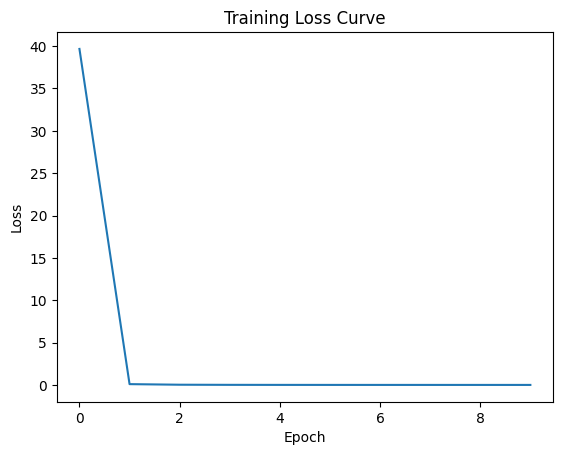

In [18]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict on entire dataset
with torch.no_grad():
    preds = model(torch.tensor(X_scaled, dtype=torch.float32)).numpy()
    preds = (preds > 0.5).astype(int)

print("Accuracy:", accuracy_score(y, preds))
print("Precision:", precision_score(y, preds))
print("Recall:", recall_score(y, preds))
print("F1 Score:", f1_score(y, preds))


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
